# Database creation
This file is used to play with the data and once the objective is reached, functions will be written in .py files in order to be used by the model part of the project.

In [1]:
from astropy.io import fits
from tabulate import tabulate
from astropy.time import Time, TimeDelta
from dataset_creation_utils import HiddenPrints, find_lower_upper_bound
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from dataset_creation_utils import *
from dataset import Dataset
# Retrieve the contrast curves from the database
path_db = 'C:/Users/ludin/Documents/Master Thesis/Dataset_creation/SPHERE_DC_DATA/contrast_curves/'
foldername = '2MASS J01543773+0043005_DB_H23_2014-10-07_ird_specal_dc_cADI_softsorting_200967/'
filename = 'ird_specal_dc-IRD_SPECAL_CONTRAST_CURVE_TABLE-contrast_curve_tab.fits'

if not os.path.exists(path_db):
    print('ERROR! Folder {} does not exist.'.format(path_db)) # exit doesn't print anything in jupyter notebook

if not os.path.exists(os.path.join(path_db, foldername)):
    print('ERROR! Folder {} does not exist.'.format(foldername))

if not os.path.exists(os.path.join(path_db, foldername, filename)):
    print('ERROR! File {} does not exist.'.format(filename))

# Example of how to read a fits file
with fits.open(os.path.join(path_db, foldername, filename)) as hdul:
    data = hdul[1].data #numpy record
    headers = hdul[1].header #dictionary
    print(data.dtype)
    # print(hdul[1].header['DATE-OBS'])
    # print(hdul[1].data['TARGET_NAME'])

(numpy.record, [('TARGET_NAME', 'S3'), ('LAM', 'S10'), ('PIXSCALE', 'S10'), ('NSIGMA', 'S3'), ('REPERTORY', 'S55'), ('SEPARATION', '>f4', (1148,)), ('NSIGMA_CONTRAST', '>f4', (1148,))])


Get a dataframe with the specified headers. Plots, summary statistics, ... can be computed if desired (not to be re-done each time).

In [2]:
dataset = Dataset(path_db, max_sep=3, write=False, plot=False)

Creating the dataset...


100%|██████████| 514/514 [01:50<00:00,  4.64it/s]


In [3]:
dataset.print_missings_percentages()
dataset.get_missings_csv()

ESO OBS ID: 0.00%
DATE-OBS: 0.00%
OBJECT: 0.00%
ESO TEL AIRM MEAN: 67.51%
EFF_NFRA: 66.93%
EFF_ETIM: 66.93%
SR_AVG: 31.71%
ESO INS4 FILT3 NAME: 0.00%
ESO INS4 OPTI22 NAME: 0.00%
ESO AOS VISWFS MODE: 0.00%
ESO TEL AMBI WINDSP: 0.00%
SCFOVROT: 0.00%
SC MODE: 0.00%
ESO TEL AMBI RHUM: 0.00%
HIERARCH ESO INS4 TEMP422 VAL: 2.53%
HIERARCH ESO TEL TH M1 TEMP: 0.00%
HIERARCH ESO TEL AMBI TEMP: 0.00%
OBS_STA: 67.51%
OBS_END: 67.51%
SIMBAD_FLUX_G: 1.56%
SIMBAD_FLUX_H: 5.25%
SEEING_MEDIAN: 68.48%
SEEING_STD: 68.48%
COHERENCE_TIME_MEDIAN: 68.48%
COHERENCE_TIME_STD: 68.48%


In [4]:
df = dataset.get_dataframe()
# df

In [5]:
# Get the min and max dates 
min_date = df['DATE-OBS'].min()
max_date = df['DATE-OBS'].max()
print('Min date: {}, max date: {}'.format(min_date, max_date))

# Get the number of observations before april 2016
df_before_april = df[df['DATE-OBS'] < '2016-04-01']
print('Number of observations before april 2016: {}'.format(len(df_before_april)))

# Get the number of observations after april 2016
df_after_april = df[df['DATE-OBS'] >= '2016-04-01']
print('Number of observations after april 2016: {}'.format(len(df_after_april)))

Min date: 2014-07-13T09:43:44.923, max date: 2019-03-25T02:18:36.930
Number of observations before april 2016: 148
Number of observations after april 2016: 366


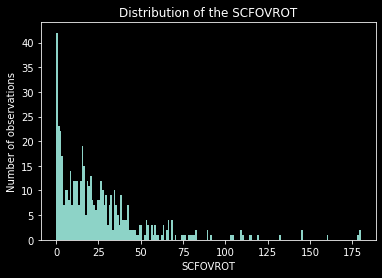

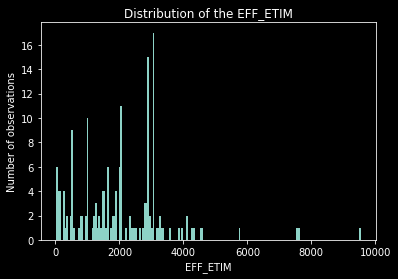

In [6]:
# Plot histogram of the wanted headers
hist_list = ['SCFOVROT', 'EFF_ETIM']

for hist in hist_list:
    try:
        plt.hist(df[hist], bins=180)
        plt.title("Distribution of the {}".format(hist))
        # plt.xlim(0, 360)
        plt.xlabel(hist)
        plt.ylabel("Number of observations")
        plt.show()
    except KeyError:
        print("ERROR! Header {} does not exist.".format(hist))

Number of observations with EFF_ETIM between 0 and 300 seconds : 18 


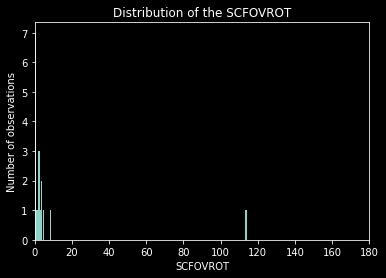

In [7]:
# Keep only the rows where EFF_ETIM is between 0 and 300
new_df = df[(df['EFF_ETIM'] > 0) & (df['EFF_ETIM'] < 300)]
print('Number of observations with EFF_ETIM between 0 and 300 seconds : {} '.format(len(new_df)))

# Plot the histogram of the SCFOVROT
plt.hist(new_df['SCFOVROT'], bins=180)
plt.title("Distribution of the SCFOVROT")
plt.xlim(0, 180)
plt.xlabel('SCFOVROT')
plt.ylabel("Number of observations")
plt.show()
# Careful, EFF_ETIM is missing for a lot of observartions !! 
# I did this part when trying to recover it frome headers with NDIT * DIT
# but Julien told me that EFF_ETIM is not the same as NDIT * DIT

This plot is a summary plot of all the contrast curves, no anomaly detection has been performed.

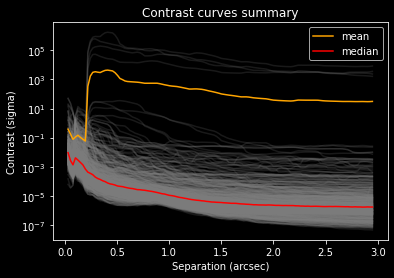

In [8]:
dataset.plot_contrast_curves_summary(filename='contrast_curves_summary_raw.png')

Now the sum of the absolute differences between the contrast curves and the median contrast curve (using log values) is used as deviation measure. The distribution of these deviations is showed and some outliers can be observed.

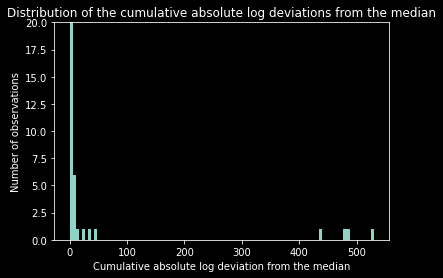

In [9]:
# Plot the distribution of the absolute deviations from the median
plt.hist(dataset.get_contrast_abs_deviations_from_median(), bins=100)	
# plt.xlim(0, 100)
plt.ylim(0, 20)
plt.title("Distribution of the cumulative absolute log deviations from the median")
plt.xlabel("Cumulative absolute log deviation from the median")
plt.ylabel("Number of observations")
plt.show()

The cut-off criterion has been chosen (arbitrarly) and a new summary plot has been computed in order to be compared to the previous one.

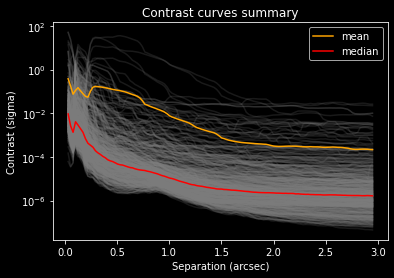

In [10]:
dataset.remove_contrast_anomalies(threshold=100)
dataset.plot_contrast_curves_summary(filename='contrast_curves_summary_anomaly_detection.png')
df_AD = dataset.get_dataframe()

In [12]:
test = {}
test['a'] = 1
test['b'] = 2
test['c'] = 3

print([''] + list(test.keys()))

['', 'a', 'b', 'c']


In [11]:
df_AD

,folder,ESO OBS ID,DATE-OBS,OBJECT,ESO TEL AIRM MEAN,EFF_NFRA,EFF_ETIM,SR_AVG,ESO INS4 FILT3 NAME,ESO INS4 OPTI22 NAME,...,OBS_STA,OBS_END,SEPARATION,NSIGMA_CONTRAST,SIMBAD_FLUX_G,SIMBAD_FLUX_H,SEEING_MEDIAN,SEEING_STD,COHERENCE_TIME_MEDIAN,COHERENCE_TIME_STD
0,++ CVN 3B_DB_H23_2018-09-14_ird_specal_dc_cADI...,2177825,2018-09-15T07:33:22.600,CD-52 381,1.14378,3360.0,2813.00,0.568267,OPEN,MEDIUM,...,2018-09-15T06:38:39.07,2018-09-15T08:28:09.83,"[0.0306249987334013, 0.05435055188410651, 0.07...","[0.0764733002369364, 0.007057913887455397, 0.0...",10.614176,8.530,"MASS-DIMM Seeing [""] 0.93 dtype: float64","MASS-DIMM Seeing [""] 0.182966 dtype: float64",MASS-DIMM Tau0 [s] 0.002132 dtype: float64,MASS-DIMM Tau0 [s] 0.000332 dtype: float64
1,++ KOH 78_DB_H23_2016-04-03_ird_specal_dc_cADI...,1182440,2016-04-04T07:59:57.849,ScoPMS_048,NaN,NaN,NaN,0.612498,OPEN,SMALL,...,NaN,NaN,"[0.0306249987334013, 0.05435055188410651, 0.07...","[0.013610598683677744, 0.005102142635421004, 0...",14.683154,8.473,NaN,NaN,NaN,NaN
2,++ SKF 1501_DB_H23_2015-04-11_ird_specal_dc_cA...,1182371,2015-04-12T07:15:49.844,HIP_76629,NaN,NaN,NaN,NaN,LP_780,SMALL,...,NaN,NaN,"[0.0306249987334013, 0.05435055188410651, 0.07...","[0.00835001855564525, 0.0022740225957848703, 0...",7.677120,5.994,NaN,NaN,NaN,NaN
3,1RXS J184646.0-363621_DB_H23_2018-07-04_ird_sp...,1962017,2018-07-05T01:24:56.950,RXJ1846,1.35900,32.0,26.79,0.203250,OPEN,MEDIUM,...,2018-07-05T01:24:27.36,2018-07-05T01:25:26.54,"[0.0306249987334013, 0.05435055188410651, 0.07...","[0.12483872406837707, 0.07288618737488416, 0.0...",10.789814,8.469,NaN,NaN,NaN,NaN
4,1RXS J184646.0-363621_DB_H23_2018-07-04_ird_sp...,1962017,2018-07-05T01:24:56.950,RXJ1846,1.35900,32.0,26.79,0.203250,OPEN,MEDIUM,...,2018-07-05T01:24:27.36,2018-07-05T01:25:26.54,"[0.0306249987334013, 0.05435055188410651, 0.07...","[0.12483872406837707, 0.07288618737488416, 0.0...",10.789814,8.469,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,TYC 7692-2943-2_DB_H23_2019-03-19_ird_specal_d...,2296758,2019-03-20T02:23:21.230,TYC 7692-2943-2,1.03000,16.0,512.00,NaN,LP_780,MEDIUM,...,2019-03-20T02:18:30.62,2019-03-20T02:28:12.11,"[0.0306249987334013, 0.05435055188410651, 0.07...","[0.010639848856919395, 0.002414968575376793, 0...",9.348000,NaN,"MASS-DIMM Seeing [""] 0.83 dtype: float64","MASS-DIMM Seeing [""] 0.082658 dtype: float64",MASS-DIMM Tau0 [s] 0.00535 dtype: float64,MASS-DIMM Tau0 [s] 0.0003 dtype: float64
510,TYC 7692-2943-2_DB_H23_2019-03-24_ird_specal_d...,2296758,2019-03-25T02:18:36.930,TYC 7692-2943-2,1.03000,63.0,2016.00,NaN,LP_780,SMALL,...,2019-03-25T01:59:18.07,2019-03-25T02:37:55.65,"[0.0306249987334013, 0.05435055188410651, 0.07...","[0.007000685686163963, 0.002920603859616869, 0...",9.348000,NaN,"MASS-DIMM Seeing [""] 0.7 dtype: float64","MASS-DIMM Seeing [""] 0.087962 dtype: float64",MASS-DIMM Tau0 [s] 0.008665 dtype: float64,MASS-DIMM Tau0 [s] 0.001704 dtype: float64
511,TYC 8092-1574-2_DB_H23_2016-10-01_ird_specal_d...,1424674,2016-10-02T08:50:23.156,HIP 28153,NaN,NaN,NaN,0.624970,OPEN,MEDIUM,...,NaN,NaN,"[0.0306249987334013, 0.05435055188410651, 0.07...","[0.007665507957330054, 0.000964130643938169, 0...",12.476170,NaN,NaN,NaN,NaN,NaN
512,TYC 8097-337-1_DB_H23_2018-10-31_ird_specal_dc...,2028801,2018-11-01T07:33:29.100,TYC 8097-337-1,1.12000,64.0,4096.00,0.714905,OPEN,MEDIUM,...,2018-11-01T06:58:19.19,2018-11-01T08:08:36.03,"[0.0306249987334013, 0.05435055188410651, 0.07...","[0.006814450366733455, 0.0032717083575035423, ...",11.274122,9.907,"MASS-DIMM Seeing [""] 0.675 dtype: float64","MASS-DIMM Seeing [""] 0.073518 dtype: float64",MASS-DIMM Tau0 [s] 0.006524 dtype: float64,MASS-DIMM Tau0 [s] 0.001182 dtype: float64
